Add Deskewed Versions of Images to HDF5 Database
===========

In [7]:
from pylab import *
from scipy.spatial import distance
from scipy.ndimage import interpolation
import tables
import random as pyrandom

In [2]:
with tables.openFile("mnist.h5","r") as mnist:
    print mnist
    images = array(mnist.root.images,'f')
    labels = array(mnist.root.labels,'i')
    test_images = array(mnist.root.test_images,'f')
    test_labels = array(mnist.root.test_labels,'i')

mnist.h5 (File) ''
Last modif.: 'Mon May 21 10:47:39 2012'
Object Tree: 
/ (RootGroup) ''
/images (CArray(60000, 28, 28), shuffle, zlib(9)) ''
/labels (CArray(60000,), shuffle, zlib(9)) ''
/test_images (CArray(10000, 28, 28), shuffle, zlib(9)) ''
/test_labels (CArray(10000,), shuffle, zlib(9)) ''

In [8]:
def moments(image):
    c0,c1 = mgrid[:image.shape[0],:image.shape[1]]
    m0 = sum(c0*image)/sum(image)
    m1 = sum(c1*image)/sum(image)
    m00 = sum((c0-m0)**2*image)/sum(image)
    m11 = sum((c1-m1)**2*image)/sum(image)
    m01 = sum((c0-m0)*(c1-m1)*image)/sum(image)
    return array([m0,m1]),array([[m00,m01],[m01,m11]])

In [9]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = array([[1,0],[alpha,1]])
    ocenter = array(image.shape)/2.0
    offset = c-dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [15]:
with tables.openFile("mnist.h5","r+") as cl:
    if "deskewed" in dir(cl.root): cl.removeNode("/deskewed")
    size = [0]+list(deskew(images[0]).shape)
    print size
    cl.createEArray(cl.root,"deskewed",tables.Float32Atom(),shape=size,filters=tables.Filters(9))
    for i,image in enumerate(images):
        cl.root.deskewed.append([deskew(image)])

[0, 28, 28]

In [16]:
with tables.openFile("mnist.h5","r+") as cl:
    if "test_deskewed" in dir(cl.root): cl.removeNode("/test_deskewed")
    size = [0]+list(deskew(images[0]).shape)
    print size
    cl.createEArray(cl.root,"test_deskewed",tables.Float32Atom(),shape=size,filters=tables.Filters(9))
    for i,image in enumerate(test_images):
        cl.root.test_deskewed.append([deskew(image)])

[0, 28, 28]

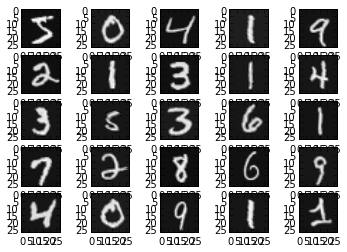

In [17]:
with tables.openFile("mnist.h5","r") as mnist:
    for i in range(25):
        subplot(5,5,i+1)
        gray()
        imshow(mnist.root.deskewed[i])